# Load Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf

# for reproducibility 
np.random.seed(42)

# Load Data

In [4]:
start_date = "2024-01-01"
end_date = pd.Timestamp.today().strftime('%Y-%m-%d')

tsla = yf.download("TSLA", start=start_date, end=end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [5]:
tsla.head()

Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2024-01-02,248.419998,251.250000,244.410004,250.080002,104654200
2024-01-03,238.449997,245.679993,236.320007,244.979996,121082600
2024-01-04,237.929993,242.699997,237.729996,239.250000,102629300
2024-01-05,237.490005,240.119995,234.899994,236.860001,92379400
2024-01-08,240.449997,241.250000,235.300003,236.139999,85166600


In [6]:
# Flatten column headers
tsla.columns = [col[0] for col in tsla.columns]

In [7]:
tsla.head(1)

,Close,High,Low,Open,Volume
Date,,,,,
2024-01-02,248.419998,251.25,244.410004,250.080002,104654200


In [8]:
# reset index
tsla.reset_index(inplace = True)

In [9]:
tsla.head(1)

,Date,Close,High,Low,Open,Volume
0,2024-01-02,248.419998,251.25,244.410004,250.080002,104654200


In [20]:
# Rename 'Close' to 'Adj Close'
tsla.rename(columns={'Close': 'Adj Close'}, inplace=True)

In [22]:
tsla.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321 entries, 0 to 320
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       321 non-null    datetime64[ns]
 1   Adj Close  321 non-null    float64       
 2   High       321 non-null    float64       
 3   Low        321 non-null    float64       
 4   Open       321 non-null    float64       
 5   Volume     321 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 15.2 KB


# Analysis

## 1. Calculate returns

In [24]:
# Calculate daily simple returns
tsla['Simple_Returns'] = tsla['Adj Close'].pct_change()

In [26]:
# Calculate daily log returns
tsla['Log_Returns'] = np.log(tsla['Adj Close'] / tsla['Adj Close'].shift(1))

In [28]:
# Drop rows with NaNs
tsla = tsla.dropna(subset=['Simple_Returns'])

## 2. Plot Returns

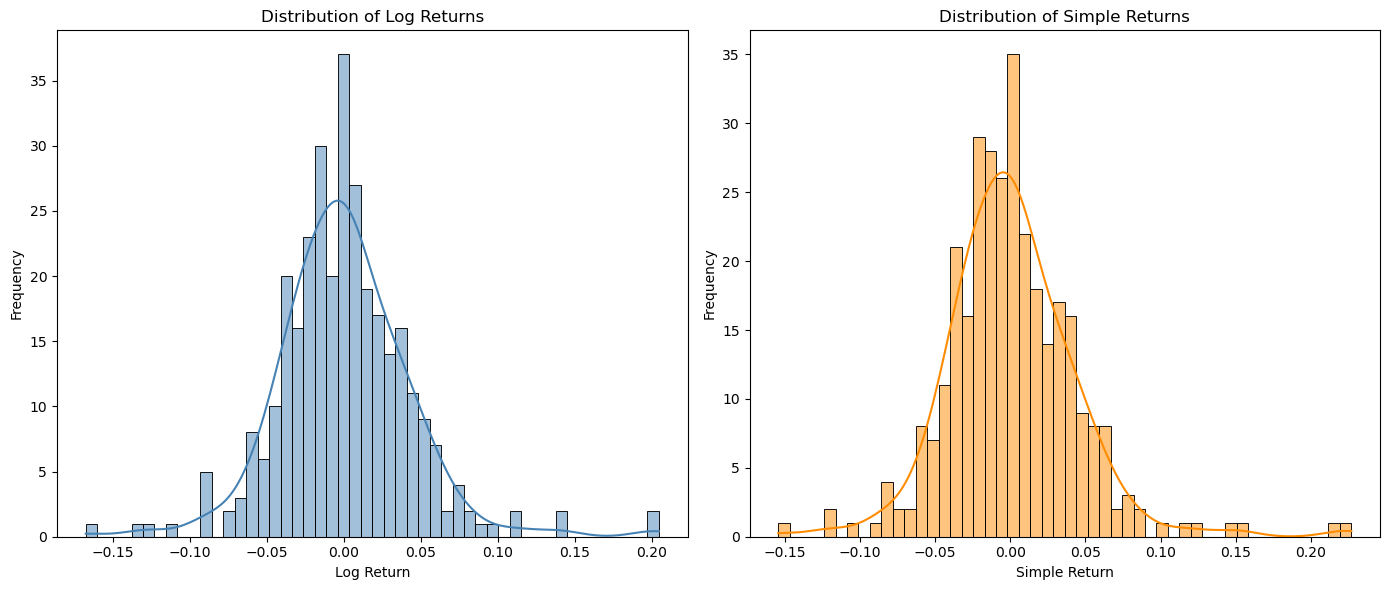

In [35]:
# Set up plot style
plt.figure(figsize=(14, 6))

# Plot log returns
plt.subplot(1, 2, 1)
sns.histplot(tsla['Log_Returns'], bins=50, kde=True, color='steelblue')
plt.title('Distribution of Log Returns')
plt.xlabel('Log Return')
plt.ylabel('Frequency')

# Plot simple returns
plt.subplot(1, 2, 2)
sns.histplot(tsla['Simple_Returns'], bins=50, kde=True, color='darkorange')
plt.title('Distribution of Simple Returns')
plt.xlabel('Simple Return')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


**Comments**
- Both simple and log returns appear to have a bell shape distribution showing clearly not perfectly normal. There is a slight left skew and fat tails for both distributions. THe peak is also very sharp indicating leptokurtosis which could mean a higher probabality of extreme returns than a normal distribution would predict

## 3. Calculate Risk Measures

#### 3.1. Historical approach

In [66]:
# Define function to calculate Historical VaR
def calculate_historical_var(series, confidence_levels=[0.95, 0.99]):
    return {
        f"{int(cl * 100)}%": -np.percentile(series.dropna(), 100 * (1 - cl))
        for cl in confidence_levels
    }

In [68]:
# Calculate Historical VaR
var_simple = calculate_historical_var(tsla['Simple_Returns'])
var_log = calculate_historical_var(tsla['Log_Returns'])

In [70]:
# Combine into DataFrame
var_table = pd.DataFrame({
    'Simple_Returns': var_simple,
    'Log_Returns': var_log
}).T

In [72]:
# Format as percentages
var_table = var_table.map(lambda x: f"{x:.2%}")
print("Historical Value at Risk (VaR):")
print(var_table)


Historical Value at Risk (VaR):
                  95%     99%
Simple_Returns  5.65%  10.11%
Log_Returns     5.82%  10.66%


**Comments**
- VaR is calculated to be slighly higher for the log returns, at both the 95% and 99% confidence levels.

In [81]:
# Define function to calculate Historical ES
def calculate_historical_es(series, confidence_levels=[0.95, 0.99]):
    es_results = {}
    sorted_returns = series.dropna().sort_values()
    n = len(sorted_returns)
    
    for cl in confidence_levels:
        cutoff_index = int((1 - cl) * n)
        tail_losses = sorted_returns[:cutoff_index]
        es_results[f"{int(cl * 100)}%"] = -tail_losses.mean()
    
    return es_results

In [83]:
# Compute ES
es_log = calculate_historical_es(tsla['Log_Returns'])
es_simple = calculate_historical_es(tsla['Simple_Returns'])

In [85]:
# Combine into DataFrame
es_table = pd.DataFrame({
    'Simple Returns': es_simple,
    'Log Returns': es_log
}).T

In [87]:
# Format as percentages
es_table = es_table.map(lambda x: f"{x:.2%}")
print("Historical Expected Shortfall (ES):")
print(es_table)

Historical Expected Shortfall (ES):
                  95%     99%
Simple Returns  8.62%  13.30%
Log Returns     9.06%  14.28%


**Comments**
- As expected, ES values are higher than VaR at each confidence level
- The difference between ES and VaR widens at higher confidence (e.g., 99%), highlighting tail risk that VaR alone may underestimate.
- Log returns again show slightly more conservative estimates, aligning with earlier VaR results.

#### 3.2. Parametric Approach

In [104]:
from scipy.stats import norm

# Use simple returns
mu = tsla['Simple_Returns'].mean()
sigma = tsla['Simple_Returns'].std()
confidence_levels = [0.95, 0.99]

In [106]:
# Calculate Parametric VaR and ES
parametric_results = {"VaR": {}, "ES": {}}

In [108]:
for cl in confidence_levels:
    z = norm.ppf(1 - cl)
    pdf = norm.pdf(z)
    
    var = -(mu + z * sigma)
    es = -mu + (sigma * pdf) / (1 - cl)

    parametric_results["VaR"][f"{int(cl*100)}%"] = var
    parametric_results["ES"][f"{int(cl*100)}%"] = es

In [110]:
# Format into DataFrames
param_var_df = pd.DataFrame(parametric_results["VaR"], index=["Parametric VaR"])
param_es_df = pd.DataFrame(parametric_results["ES"], index=["Parametric ES"])

In [112]:
# Combine and format
param_table = pd.concat([param_var_df, param_es_df])
param_table = param_table.map(lambda x: f"{x:.2%}")

In [114]:
print("Parametric (Normal) VaR and ES:")
print(param_table)

Parametric (Normal) VaR and ES:
                  95%     99%
Parametric VaR  7.06%  10.03%
Parametric ES   8.88%  11.50%


In [126]:
# Use log returns for parametric estimation
mu_log = tsla['Log_Returns'].mean()
sigma_log = tsla['Log_Returns'].std()
confidence_levels = [0.95, 0.99]

In [128]:
# Containers for results
parametric_lognorm_var = {}
parametric_lognorm_es = {}

In [130]:
for cl in confidence_levels:
    z = norm.ppf(1 - cl)
    # Log-normal VaR: proportion of value lost
    loss = 1 - np.exp(mu_log + z * sigma_log)
    parametric_lognorm_var[f"{int(cl * 100)}%"] = loss

In [132]:
# Number of simulations for ES
n_sim = 100000
simulated_z = np.random.normal(0, 1, n_sim)

for cl in confidence_levels:
    z_cutoff = norm.ppf(1 - cl)
    
    # ---- Log-Normal VaR ----
    var = 1 - np.exp(mu_log + z_cutoff * sigma_log)
    parametric_lognorm_var[f"{int(cl * 100)}%"] = var

    # ---- Log-Normal ES (simulation) ----
    tail_z = simulated_z[simulated_z <= z_cutoff]
    simulated_returns = np.exp(mu_log + sigma_log * tail_z)
    es = 1 - simulated_returns.mean()
    parametric_lognorm_es[f"{int(cl * 100)}%"] = es

In [138]:
# Create formatted DataFrames
lognorm_var_df = pd.DataFrame(parametric_lognorm_var, index=["Log-Normal VaR"])
lognorm_es_df = pd.DataFrame(parametric_lognorm_es, index=["Log-Normal ES"])
lognorm_results = pd.concat([lognorm_var_df, lognorm_es_df])
lognorm_results = lognorm_results.map(lambda x: f"{x:.2%}")

In [140]:
# Display results
print("Parametric Log-Normal VaR and ES (using log returns):")
print(lognorm_results)

Parametric Log-Normal VaR and ES (using log returns):
                  95%     99%
Log-Normal VaR  6.80%   9.49%
Log-Normal ES   8.46%  10.79%


**comments**
- The VaR estimates are slightly lower than the historical ones. This is because the normal distribution underestimates fat tails and ignores extreme losses present in real data.
- Compared to historical ES, log-normal ES is typically more optimistic, again due to the assumption of light tails.

# 4. Evaluate Risk Measures

In [147]:
def bootstrap_var_es(series, confidence_levels=[0.95, 0.99], n_bootstrap=1000):
    var_boot = {f"{int(cl * 100)}%": [] for cl in confidence_levels}
    es_boot = {f"{int(cl * 100)}%": [] for cl in confidence_levels}
    
    series = series.dropna().values

    for _ in range(n_bootstrap):
        sample = np.random.choice(series, size=len(series), replace=True)
        sorted_sample = np.sort(sample)

        for cl in confidence_levels:
            cutoff_idx = int((1 - cl) * len(sample))
            var = -np.percentile(sample, 100 * (1 - cl))
            es = -sorted_sample[:cutoff_idx].mean()
            var_boot[f"{int(cl * 100)}%"].append(var)
            es_boot[f"{int(cl * 100)}%"].append(es)

    # Compute standard errors
    var_se = {cl: np.std(var_boot[cl]) for cl in var_boot}
    es_se = {cl: np.std(es_boot[cl]) for cl in es_boot}
    
    return pd.DataFrame({
        'VaR Std. Error': var_se,
        'ES Std. Error': es_se
}).T

In [149]:
# Run bootstrap for both return types
se_log = bootstrap_var_es(tsla['Log_Returns'])
se_simple = bootstrap_var_es(tsla['Simple_Returns'])

In [150]:
# Rename for clarity
se_log.index = ['VaR Std. Error (Log)', 'ES Std. Error (Log)']
se_simple.index = ['VaR Std. Error (Simple)', 'ES Std. Error (Simple)']

In [155]:
# Combine
se_table = pd.concat([se_log, se_simple])
se_table = se_table.map(lambda x: f"{x:.4%}")

In [157]:
print("Standard Errors from Bootstrapping (Historical Estimates):")
print(se_table)

Standard Errors from Bootstrapping (Historical Estimates):
                             95%      99%
VaR Std. Error (Log)     0.5649%  1.8934%
ES Std. Error (Log)      1.0123%  1.8520%
VaR Std. Error (Simple)  0.5563%  1.6660%
ES Std. Error (Simple)   0.9171%  1.6129%


In [159]:
def bootstrap_ci(series, confidence_levels=[0.95, 0.99], n_bootstrap=1000, ci_level=0.95):
    var_boot = {f"{int(cl * 100)}%": [] for cl in confidence_levels}
    es_boot = {f"{int(cl * 100)}%": [] for cl in confidence_levels}
    
    series = series.dropna().values

    for _ in range(n_bootstrap):
        sample = np.random.choice(series, size=len(series), replace=True)
        sorted_sample = np.sort(sample)

        for cl in confidence_levels:
            cutoff_idx = int((1 - cl) * len(sample))
            var = -np.percentile(sample, 100 * (1 - cl))
            es = -sorted_sample[:cutoff_idx].mean()
            var_boot[f"{int(cl * 100)}%"].append(var)
            es_boot[f"{int(cl * 100)}%"].append(es)

    # CI bounds
    lower_q = (1 - ci_level) / 2 * 100
    upper_q = 100 - lower_q

    ci_var = {
        cl: (np.percentile(var_boot[cl], lower_q), np.percentile(var_boot[cl], upper_q))
        for cl in var_boot
    }
    ci_es = {
        cl: (np.percentile(es_boot[cl], lower_q), np.percentile(es_boot[cl], upper_q))
        for cl in es_boot
    }

    # Format into DataFrames
    ci_var_df = pd.DataFrame(ci_var, index=['VaR Lower Bound', 'VaR Upper Bound']).T
    ci_es_df = pd.DataFrame(ci_es, index=['ES Lower Bound', 'ES Upper Bound']).T

    return ci_var_df, ci_es_df

In [161]:
# Run for both log and simple returns
ci_var_log, ci_es_log = bootstrap_ci(tsla['Log_Returns'])
ci_var_simple, ci_es_simple = bootstrap_ci(tsla['Simple_Returns'])

In [162]:
# Combine and format
ci_log = pd.concat([ci_var_log, ci_es_log], axis=1)
ci_log.index.name = "Log Returns"
ci_simple = pd.concat([ci_var_simple, ci_es_simple], axis=1)
ci_simple.index.name = "Simple Returns"

In [165]:
# Format as percentages
ci_log = ci_log.applymap(lambda x: f"{x:.2%}")
ci_simple = ci_simple.applymap(lambda x: f"{x:.2%}")

C:\Users\Inno Mvula\AppData\Local\Temp\ipykernel_11664\2621333728.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ci_log = ci_log.applymap(lambda x: f"{x:.2%}")
C:\Users\Inno Mvula\AppData\Local\Temp\ipykernel_11664\2621333728.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ci_simple = ci_simple.applymap(lambda x: f"{x:.2%}")


In [169]:
print(" 95% Confidence Intervals (Historical Estimates) — Log Returns:")
print(ci_log)
print("\n 95% Confidence Intervals (Historical Estimates) — Simple Returns:")
print(ci_simple)

 95% Confidence Intervals (Historical Estimates) — Log Returns:
            VaR Lower Bound VaR Upper Bound ES Lower Bound ES Upper Bound
Log Returns                                                              
95%                   5.06%           7.49%          7.25%         11.05%
99%                   8.44%          13.16%          9.67%         16.75%

 95% Confidence Intervals (Historical Estimates) — Simple Returns:
               VaR Lower Bound VaR Upper Bound ES Lower Bound ES Upper Bound
Simple Returns                                                              
95%                      4.90%           7.21%          6.85%         10.40%
99%                      8.09%          14.48%          9.33%         15.43%
